In [15]:
import keras
from keras import layers, models, optimizers 
from keras import backend as K
from collections import namedtuple, deque
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
import datetime
import math
from numpy.random import choice
import random
from collections import deque

### Data

In [16]:
import yfinance as yf

dataset = yf.download('PETR4.SA', period='5y')
dataset.shape

[*********************100%***********************]  1 of 1 completed


(1244, 6)

In [17]:
set_option('display.width', 100)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-26,14.16,14.49,14.00,14.00,9.657948,37045000
2017-04-27,13.99,14.03,13.56,13.73,9.471689,29078500
2017-04-28,13.85,14.10,13.69,13.97,9.637253,31061200
2017-05-02,14.06,14.34,13.85,13.99,9.651052,37830100
2017-05-03,14.04,14.25,13.95,14.16,9.768324,38357600


<AxesSubplot:xlabel='Date'>

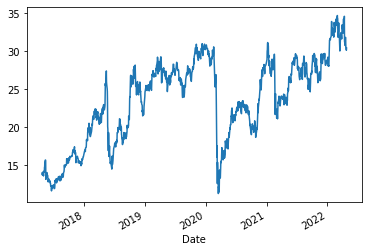

In [18]:
dataset.Close.plot()

### Data Preparation

In [19]:
#Checking for any null values and removing the null values'''
print('Null Values =', dataset.isnull().values.any())

Null Values = False


In [20]:
# Train/Test Split
X=list(dataset["Close"])
X=[float(x) for x in X]
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

### Model

The algorithm, in simple terms, decides whether to buy, sell, or hold when provided
with the current market price.

In [21]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # hold, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model("models/" + model_name) if is_eval else self._model()

    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        #1: prepare replay memory
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])

        #2: Loop across the replay memory batch.
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t
            #3: update the target for Q table. table equation
            if not done:
                target = reward + self.gamma * \
                np.amax(self.model.predict(next_state)[0])
            #set_trace()

            # 4: Q-value of the state currently from the table
            target_f = self.model.predict(state)
            
            # 5: Update the output Q table for the given action in the table
            target_f[0][action] = target
            
            # 6. train and fit the model.
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        #7. Implement epsilon greedy algorithm
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [22]:
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))

    return np.array([res])

def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15, 5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label='Buying signal', markevery=states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label='Selling signal',markevery=states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    plt.show();

def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

### Training the Model

In [25]:
window_size = 1
agent = Agent(window_size)
data = X_train
l = len(data) - 1
batch_size = 16
states_sell = []
states_buy = []
episode_count = 5

Episode 0/5
Buy: $14.00
Sell: $13.73 | Profit: -$0.27
Buy: $14.16
Buy: $13.60
Buy: $14.08
Buy: $14.14
Sell: $15.45 | Profit: $1.29
Sell: $15.68 | Profit: $2.08
Buy: $15.70
Sell: $15.61 | Profit: $1.53
Sell: $13.15 | Profit: -$0.99
Sell: $13.62 | Profit: -$2.08
Buy: $13.74
Sell: $13.68 | Profit: -$0.06
Buy: $13.05
Sell: $13.18 | Profit: $0.13
Buy: $12.87
Sell: $12.84 | Profit: -$0.03
Buy: $12.94
Sell: $12.62 | Profit: -$0.32
Buy: $12.28
Buy: $12.29
Sell: $11.86 | Profit: -$0.42
Sell: $11.64 | Profit: -$0.65
Buy: $12.27
Buy: $12.21
Sell: $12.18 | Profit: -$0.09
Buy: $12.37
Buy: $12.36
Buy: $12.43
Buy: $12.21
Buy: $12.17
Sell: $11.98 | Profit: -$0.23
Sell: $12.94 | Profit: $0.57
Sell: $12.87 | Profit: $0.51
Sell: $13.05 | Profit: $0.62
Buy: $12.89
Buy: $12.94
Sell: $13.23 | Profit: $1.02
Buy: $13.10
Buy: $12.69
Sell: $12.88 | Profit: $0.71
Sell: $13.22 | Profit: $0.33
Sell: $13.06 | Profit: $0.12
Buy: $13.00
Sell: $13.13 | Profit: $0.03
Sell: $13.29 | Profit: $0.60
Buy: $13.31
Sell: $13.4

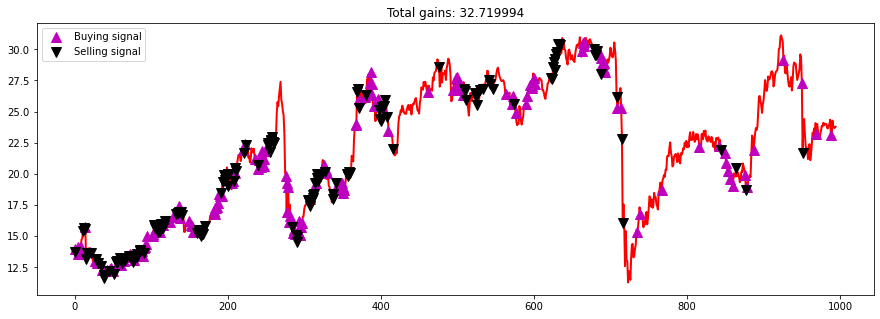

INFO:tensorflow:Assets written to: models/model_ep0\assets
Episode 1/5
Buy: $13.15
Buy: $13.40
Sell: $12.90 | Profit: -$0.25
Buy: $12.28
Sell: $11.86 | Profit: -$1.54
Sell: $11.64 | Profit: -$0.64
Buy: $15.69
Sell: $16.78 | Profit: $1.09
Buy: $16.10
Sell: $15.87 | Profit: -$0.23
Buy: $15.84
Sell: $15.33 | Profit: -$0.51
Buy: $15.48
Sell: $15.75 | Profit: $0.27
Buy: $19.97
Buy: $19.04
Sell: $21.03 | Profit: $1.06
Sell: $22.12 | Profit: $3.08
Buy: $26.29
Buy: $26.09
Buy: $26.24
Buy: $26.80
Sell: $25.55 | Profit: -$0.74
Sell: $25.99 | Profit: -$0.10
Sell: $26.20 | Profit: -$0.04
Sell: $25.86 | Profit: -$0.94
Buy: $13.00
Buy: $12.00
Buy: $11.50
Buy: $13.25
Sell: $14.32 | Profit: $1.32
Sell: $13.30 | Profit: $1.30
Sell: $13.38 | Profit: $1.88
Sell: $13.99 | Profit: $0.74
Buy: $15.77
Buy: $16.40
Buy: $17.32
Buy: $16.82
Sell: $15.72 | Profit: -$0.05
Buy: $16.75
Buy: $16.95
Buy: $15.95
Buy: $16.45
Buy: $17.25
Buy: $18.20
Buy: $17.94
Buy: $17.44
Buy: $18.48
Buy: $18.15
Buy: $18.14
Buy: $17.59
B

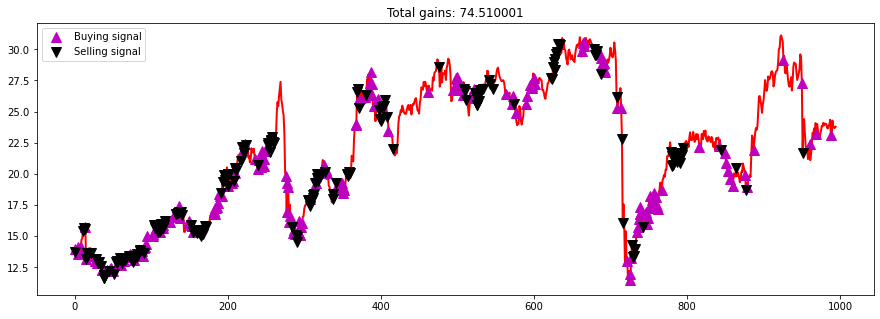

Episode 2/5
Buy: $26.08
Sell: $26.25 | Profit: $0.17
Buy: $25.65
Sell: $25.79 | Profit: $0.14


KeyboardInterrupt: 

In [26]:
for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count))
    
    # 1-get state
    state = getState(data, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []

    for t in range(l):
        # 2-apply best action
        action = agent.act(state)
        
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)

            #3: Get Reward
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False

        # 4: get next state to be used in bellman's equation
        next_state = getState(data, t + 1, window_size + 1)
        
        # 5: add to the memory
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            plot_behavior(data, states_buy, states_sell, total_profit)

        # 6: Run replay buffer function
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)
    
    if e % 10 == 0:
        agent.model.save("models/model_ep" + str(e))

In [ ]:
print(agent.model.summary())

### Testing the Model

In [ ]:
#agent is already defined in the training set above.
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
model_name = "model_ep10"
agent = Agent(window_size, is_eval, model_name)
state = getState(dataset, 0, window_size + 1)
total_profit = 0
agent.inventory = []

In [ ]:
for t in range(l_test):
    action = agent.act(state)
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        print("Buy: " + formatPrice(test_data[t]))
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        total_profit += test_data[t] - bought_price
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " +\
        formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state
    
    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")

plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)